In [ ]:
!pip -q install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sornels","key":"d3241f92d3423f9d91d9e9e1d140fbdf"}'}

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d cdc/national-health-and-nutrition-examination-survey
! unzip /content/national-health-and-nutrition-examination-survey.zip

  0% 0.00/6.87M [00:00<?, ?B/s]
100% 6.87M/6.87M [00:00<00:00, 79.7MB/s]
Archive:  /content/national-health-and-nutrition-examination-survey.zip
  inflating: demographic.csv         
  inflating: diet.csv                
  inflating: examination.csv         
  inflating: labs.csv                
  inflating: medications.csv         
  inflating: questionnaire.csv       


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn import linear_model
from sklearn.svm import SVC
# from sklearn.crossvalidation import KFold
from sklearn.metrics import mean_squared_error, r2_score
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


## Read CSV files

In [ ]:
df={}
for filename in os.listdir('/content/'):
    if filename.endswith('.csv'):
        key = filename.split('.')[0]  # Extract the first string before ".csv"
        filepath = os.path.join('/content/', filename)
        dataframe = pd.read_csv(filepath,encoding='ISO-8859-1')
        df[key] = dataframe

In [ ]:
labs=df['labs']
q_df=df['questionnaire']
ex_df=df['examination']
dem=df['demographic']


In [ ]:
display(df['demographic'].head())
print(df['demographic'].columns)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,3.0,4.0,NaN,13281.237386,13481.042095,1,112,4.0,4.0,0.84
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,4.0,1.0,3.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,3.0,1.0,4.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,5.0,1.0,5.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00


Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC',
       'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL',
       'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY',
       'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ',
       'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGE',
       'DMDHRBR4', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU', 'WTINT2YR', 'WTMEC2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR'],
      dtype='object')


In [ ]:
display(df['questionnaire'].head())
print(df['questionnaire'].columns)


,SEQN,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,3.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,1.0,NaN,NaN,NaN,NaN,1.0,NaN,7.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


Index(['SEQN', 'ACD011A', 'ACD011B', 'ACD011C', 'ACD040', 'ACD110', 'ALQ101',
       'ALQ110', 'ALQ120Q', 'ALQ120U',
       ...
       'WHD080U', 'WHD080L', 'WHD110', 'WHD120', 'WHD130', 'WHD140', 'WHQ150',
       'WHQ030M', 'WHQ500', 'WHQ520'],
      dtype='object', length=953)


In [ ]:
display(df['demographic'].head())
print(df['demographic'].columns)

In [ ]:
merged=dem.merge(q_df, on='SEQN', how='left')
merged=merged.merge(labs, on='SEQN', how='left')
merged=merged.merge(ex_df, on='SEQN', how='left')

### Column Mapping

In [ ]:
#depression
column_mapping_DEPRESSION={
    "DPQ010": "Little interest in doing things",
    "DPQ020": "Feeling down or depressed",
    "DPQ030": "Trouble sleeping",
    "DPQ040": "Feeling tired or low energy",
    "DPQ050": "Poor appetite or overeating",
    "DPQ060": "Negative self-perception",
    "DPQ070": "Trouble concentrating",
    "DPQ080": "Altered movement or speech",
    "DPQ090": "Thoughts of self-harm"}
#Blood Pressure
column_mapping_bp={
    "BPQ040A": "Prescription for hypertension",
    "BPQ080": "High cholesterol level",
    "BPQ090D": "Prescription for cholesterol",
    "BPQ100D": "Taking cholesterol medicine"
}

#Health
column_mapping_health_symtpmoms={

    "DIQ010": "Diagnosed with diabetes",
    "DIQ160": "Diagnosed with prediabetes",
    "DIQ170": "Told about health risk for diabetes",
    "DIQ172": "Feel at risk for diabetes",
    "DIQ175B": "Overweight",
    "DIQ175D": "Poor diet",
    "DIQ175F": "Had a baby weighed over 9 lbs. at birth",
    "DIQ175G": "Lack of physical activity",
    "DIQ175H": "High blood pressure",
    "DIQ175I": "High blood sugar",
    "DIQ175J": "High cholesterol",
    "DIQ175K": "Hypoglycemic",
    "DIQ175L": "Extreme hunger",
    "DIQ175M": "Tingling/numbness in hands or feet",
    "DIQ175N": "Blurred vision",
    "DIQ175O": "Increased fatigue",
    "DIQ175Q": "Doctor warning",
    "DIQ175S": "Gestational diabetes",
    "DIQ175T": "Frequent urination",
    "DIQ175U": "Thirst",
    "DIQ175V": "Craving for sweet/eating a lot of sugar",
    "SLD010H": "Hours of sleep per night",
    "SLQ050": "Told doctor about trouble sleeping",
    "SLQ060": "Told about sleep disorder",
    "BMXBMI": "BMI"


}

#Chronic_Diseases
chronic_disease = {
    "MCQ010": "asthma",
    "MCQ160B": "congestive_heart_failure",
    "MCQ160E": "heart_attack",
    "MCQ160M": "thyroid_problem",
    "MCQ160L": "liver_condition",
    "MCQ220": "cancer",
    "MCQ365A": "doctor_told_lose_weight",
    "MCQ365B": "doctor_told_exercise",
    "MCQ365C": "doctor_told_reduce_salt",
    "MCQ365D": "doctor_told_reduce_fat_calories",
    "KIQ022": "weak_failing_kidneys",
    "KIQ026": "kidney_stones"
}

smoking = {
    "SMQ020": "Smoked_100+_cigarettes",
    "SMQ040": "Currently_smoke_cigarettes",
    "SMD641": "Days_smoked_past_30_days",
    "ALQ101": "Had_12+_alcohol_drinks_per_year",
    "ALQ110": "Had_12+_alcohol_drinks_lifetime",
    "ALQ120U": "Days_drink_alcohol_per_week_month_year"
}

#Lab examinations
labs= {
    "LBDHDD": "Direct_HDL-Cholesterol (mg/dL)",
    "LBDVIDLC": "Vitamin_D",
    "LBDB12": "Vitamin_B12"
}

work_behavior={ "OCQ180": "Hours worked last week",
    "OCQ210": "Usually 35+ hours/week"}

physical_activity = {
    "PFQ020": "Crawl, walk limitations",
    "PFQ030": "Long term health problem",
    "PFQ049": "Limitations for working",
    "PFQ061B": "Walking 1/4 mile difficulty",
    "PFQ061C": "Walking up 10 steps difficulty",
    "PFQ061E": "Lifting or carrying difficulty",
    "PFQ061J": "Getting in/out of bed difficulty",
    "PFQ061Q": "Going out to events difficulty"
}

#Demographics

dem_columns = {
    "SEQN":"SEQN",
    "RIAGENDR": "Gender",
    "RIDAGEYR": "Age",
    "RIDRETH1": "Race",
    "DMDBORN4": "Country of Birth",
    "DMDEDUC2": "Education Level (Self)",
    "DMDEDUC3": "Education Level (Spouse)",
    "DMDFMSIZ": "Family Size",
    "DMDHHSIZ": "Household Size",
    "DMDHHSZA": "Children Aged 5 or Younger in Household",
    "DMDHHSZB": "Children Aged 6-17 in Household",
    "DMDHHSZE": "Adults Aged 60 or Older in Household",
    "DMDHREDU": "HH Reference Person's Education Level",
    "DMDHRGND": "HH Reference Person's Gender",
    "DMDHRMAR": "HH Reference Person's Marital Status",
    "DMDHSEDU": "HH Reference Person's Spouse's Education Level",
    "DMDMARTL": "Marital Status",
    "DMDYRSUS": "Length of Time in US",
    "FIALANG": "Family Interview Instrument Language",
    "INDFMPIR": "Ratio of Family Income to Poverty Guidelines",
    "INDHHIN2": "Annual  Household Income"
}


In [ ]:
dictionary_names = [column_mapping_DEPRESSION, dem_columns, column_mapping_bp, column_mapping_health_symtpmoms, chronic_disease, smoking, labs, work_behavior, physical_activity]


In [ ]:
list(labs.keys())+list(work_behavior.keys())+list(physical_activity.keys())

['LBDHDD',
 'LBDVIDLC',
 'LBDB12',
 'OCQ180',
 'OCQ210',
 'PFQ020',
 'PFQ030',
 'PFQ049',
 'PFQ061B',
 'PFQ061C',
 'PFQ061E',
 'PFQ061J',
 'PFQ061Q']

In [ ]:
#Renaming Columns
dictionary_names = [column_mapping_DEPRESSION, dem_columns, column_mapping_bp, column_mapping_health_symtpmoms, chronic_disease, smoking, labs, work_behavior, physical_activity]
for i in range(len(dictionary_names)):
  merged.rename(columns=dictionary_names[i], inplace=True)

#Extracting Columns
columns_to_extract = [col for col_dict in dictionary_names for col in col_dict.values()]
extracted_columns = []

for col in columns_to_extract:
    try:
        extracted_data = merged[col]
        extracted_columns.append(col)
    except KeyError:
        print(f"Column '{col}' not found. Skipping...")


Column 'weak_failing_kidneys' not found. Skipping...
Column 'kidney_stones' not found. Skipping...
Column 'Vitamin_D' not found. Skipping...


In [ ]:
#Selecting Columns and Age Group
clean_df=merged[merged['Age']>=18][extracted_columns]

,SEQN,SDDSRVYR,RIDSTATR,Gender,Age,RIDAGEMN,Race,RIDRETH3,RIDEXMON,RIDEXAGM,...,CSXLEAOD,CSXSOAOD,CSXGRAOD,CSXONOD,CSXNGSOD,CSXSLTRT,CSXSLTRG,CSXNART,CSXNARG,CSAEFFRT
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,2.0,1.0,1.0,1.0,4.0,62.0,1.0,NaN,NaN,1.0
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,2.0,3.0,4.0,28.0,1.0,NaN,NaN,1.0
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,2.0,1.0,2.0,3.0,4.0,49.0,1.0,NaN,NaN,3.0
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,3.0,1.0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0
5,73562,8,2,1,56,NaN,1,1,1.0,NaN,...,3.0,1.0,2.0,3.0,4.0,21.0,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10166,83723,8,2,1,61,NaN,1,1,2.0,NaN,...,3.0,1.0,2.0,3.0,4.0,NaN,NaN,15.0,1.0,2.0
10167,83724,8,2,1,80,NaN,3,3,1.0,NaN,...,3.0,1.0,4.0,3.0,1.0,20.0,1.0,NaN,NaN,1.0
10169,83726,8,2,1,40,NaN,1,1,1.0,NaN,...,1.0,1.0,2.0,3.0,4.0,NaN,NaN,43.0,1.0,1.0
10170,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Cleaning Columns


In [ ]:
#Replacing Columns with 99 and 77 Values
selected_columns = []
other_cols = []
columns_q = [col for col in clean_df.columns if col not in ['Age', 'SEQN']]
# Finding out the unique values of each column
for column in columns_q:
    unique_values = clean_df[column].unique()
    if len(unique_values) == 3 and 1 in unique_values and 2 in unique_values:
        selected_columns.append(column)
    elif len(unique_values) == 5 and all(item in unique_values for item in [77., 99.]):
        other_cols.append(column)

In [ ]:
clean_df = clean_df.loc[:,~clean_df.columns.duplicated()]

##Replacing Columns with 99 and 77 Values



In [ ]:
selected_columns = [col for col in clean_df.columns if any(isinstance(val, (int, float)) and val > 9 for val in clean_df[col].unique())]
for x in selected_columns:
  print(x, clean_df[x].unique())


columns_to_replace = ['Education Level (Spouse)', "HH Reference Person's Marital Status", 'Marital Status', 'Length of Time in US', 'Annual  Household Income', 'Hours of sleep per night','Country of Birth']

clean_df[columns_to_replace] = clean_df[columns_to_replace].replace({99.0: np.nan, 77.0: np.nan})



Education Level (Spouse) [nan 15. 11.  9. 10. 13. 12. 14. 66.]
HH Reference Person's Marital Status [ 4.  1.  3.  2.  5.  6. nan 77. 99.]
Marital Status [ 4.  1.  3.  2.  5.  6. nan 77. 99.]
Length of Time in US [nan  4.  6.  3.  7.  2.  9.  8.  5. 99. 77.  1.]
Annual  Household Income [ 4.  7. 10. 15.  9.  3. 14.  8.  5. 12. nan 13.  2.  6.  1. 77. 99.]
Overweight [nan 11.]
Poor diet [nan 13.]
Had a baby weighed over 9 lbs. at birth [nan 15.]
Lack of physical activity [nan 16.]
High blood pressure [nan 17.]
High blood sugar [nan 18.]
High cholesterol [nan 19.]
Hypoglycemic [nan 20.]
Extreme hunger [nan 21.]
Tingling/numbness in hands or feet [nan 22.]
Blurred vision [nan 23.]
Increased fatigue [nan 24.]
Doctor warning [nan 26.]
Gestational diabetes [nan 28.]
Frequent urination [nan 29.]
Thirst [nan 30.]
Craving for sweet/eating a lot of sugar [nan 31.]
Hours of sleep per night [ 7.  9.  8.  5.  6. 10.  4.  3. 12.  2. 99. 11. nan]
BMI [26.7 28.6 28.9 19.7 41.7 35.7  nan 26.5 22.  20.3 

### Dropping Columns That Have no text data

In [ ]:
conditions_list = [
    'Overweight',
    'Poor diet',
    'Had a baby weighed over 9 lbs. at birth',
    'Lack of physical activity',
    'High blood pressure',
    'High blood sugar',
    'High cholesterol',
    'Hypoglycemic',
    'Extreme hunger',
    'Tingling/numbness in hands or feet',
    'Blurred vision',
    'Increased fatigue',
    'Doctor warning',
    'Gestational diabetes',
    'Frequent urination',
    'Thirst',
    'Craving for sweet/eating a lot of sugar'
]


## Cleaning Income Values

In [ ]:
data_dict = {
    1.0: 1,
    2.0: 1,
    3.0: 1,
    4.0: 1,
    5.0: 1,
    6.0: 1,
    7.0: 2,
    8.0: 2,
    9.0: 2,
    10.0: 3,
    12.0: 2,
    13.0: 1,
    14.0: 3
}


clean_df['Annual  Household Income']=clean_df['Annual  Household Income'].map(data_dict)

In [ ]:
for x in selected_columns:
  print(x, clean_df[x].unique())

clean_df.drop(columns=conditions_list, inplace=True)

Education Level (Spouse) [nan 15. 11.  9. 10. 13. 12. 14. 66.]
HH Reference Person's Marital Status [ 4.  1.  3.  2.  5.  6. nan]
Marital Status [ 4.  1.  3.  2.  5.  6. nan]
Length of Time in US [nan  4.  6.  3.  7.  2.  9.  8.  5.  1.]
Annual  Household Income [ 1.  2.  3. nan]
Overweight [nan 11.]
Poor diet [nan 13.]
Had a baby weighed over 9 lbs. at birth [nan 15.]
Lack of physical activity [nan 16.]
High blood pressure [nan 17.]
High blood sugar [nan 18.]
High cholesterol [nan 19.]
Hypoglycemic [nan 20.]
Extreme hunger [nan 21.]
Tingling/numbness in hands or feet [nan 22.]
Blurred vision [nan 23.]
Increased fatigue [nan 24.]
Doctor warning [nan 26.]
Gestational diabetes [nan 28.]
Frequent urination [nan 29.]
Thirst [nan 30.]
Craving for sweet/eating a lot of sugar [nan 31.]
Hours of sleep per night [ 7.  9.  8.  5.  6. 10.  4.  3. 12.  2. nan 11.]
BMI [26.7 28.6 28.9 19.7 41.7 35.7  nan 26.5 22.  20.3 34.4 22.8 35.6 35.9
 23.6 18.6 30.1 26.2 31.  24.7 31.2 38.3 32.  31.8 36.8 34.9

In [ ]:
selected_columns_2 = [col for col in clean_df.columns if any(str(val).isdigit() and int(val) > 9 for val in clean_df[col].unique())]

for x in selected_columns_2:
  print(x, clean_df[x].unique())

# clean_df['Annual Household Income']

SEQN [73557 73558 73559 ... 83726 83727 83729]
Age [69 54 72 73 56 61 42 65 26 76 33 32 18 38 50 23 28 35 29 58 57 20 37 75
 43 60 55 62 36 80 31 63 71 67 64 46 44 19 70 59 25 39 24 30 49 45 51 77
 78 66 79 47 48 53 21 68 52 34 40 27 41 22 74]


In [ ]:
# selected_columns = [col for col in clean_df.columns if any(isinstance(val, (int, float)) and val > 6 for val in clean_df[col].unique())]
change=[]
for x in clean_df.columns:
  if clean_df[x].nunique()<=7 and clean_df[x].nunique()>2 :
    # print(x, clean_df[x].unique())
    change.append(x)

clean_df[change] = clean_df[change].replace({9: np.nan, 7: np.nan})


In [ ]:
#View unique values in depression columns
for x in column_mapping_DEPRESSION.values():
  print(x,clean_df[x].unique())
  clean_df[column_mapping_DEPRESSION.values()]


Little interest in doing things [ 1.  2.  0.  3. nan]
Feeling down or depressed [ 0.  1.  3. nan  2.]
Trouble sleeping [ 0.  3. nan  1.  2.]
Feeling tired or low energy [ 0.  3.  1. nan  2.]
Poor appetite or overeating [ 0.  3. nan  1.  2.]
Negative self-perception [ 0.  1. nan  3.  2.]
Trouble concentrating [ 0.  2. nan  1.  3.]
Altered movement or speech [ 0.  1. nan  3.  2.]
Thoughts of self-harm [ 0. nan  1.  3.  2.]


In [ ]:

missing_values = clean_df.isnull().sum()
missing_percentage = (missing_values / len(clean_df)) * 100
columns_to_highlight = missing_percentage[missing_percentage > 5].index
list(columns_to_highlight)
# print(missing_percentage[missing_percentage > 5])

['Little interest in doing things',
 'Feeling down or depressed',
 'Trouble sleeping',
 'Feeling tired or low energy',
 'Poor appetite or overeating',
 'Negative self-perception',
 'Trouble concentrating',
 'Altered movement or speech',
 'Thoughts of self-harm',
 'Education Level (Self)',
 'Education Level (Spouse)',
 'Family Size',
 'Household Size',
 "HH Reference Person's Spouse's Education Level",
 'Marital Status',
 'Length of Time in US',
 'Ratio of Family Income to Poverty Guidelines',
 'Annual  Household Income',
 'Prescription for hypertension',
 'Prescription for cholesterol',
 'Taking cholesterol medicine',
 'Diagnosed with prediabetes',
 'Told about health risk for diabetes',
 'Feel at risk for diabetes',
 'congestive_heart_failure',
 'heart_attack',
 'thyroid_problem',
 'liver_condition',
 'cancer',
 'Currently_smoke_cigarettes',
 'Days_smoked_past_30_days',
 'Had_12+_alcohol_drinks_per_year',
 'Had_12+_alcohol_drinks_lifetime',
 'Days_drink_alcohol_per_week_month_year',
 

In [ ]:
#Sum the total depression questions to get depression score
clean_df['dep_score']=clean_df[column_mapping_DEPRESSION.values()].sum(axis=1)

##Creating Depression Variables

Little interest in doing things    721
Feeling down or depressed          723
Trouble sleeping                   719
Feeling tired or low energy        719
Poor appetite or overeating        720
Negative self-perception           723
Trouble concentrating              722
Altered movement or speech         722
Thoughts of self-harm              723
dep_score                            0
dtype: int64


<Axes: >

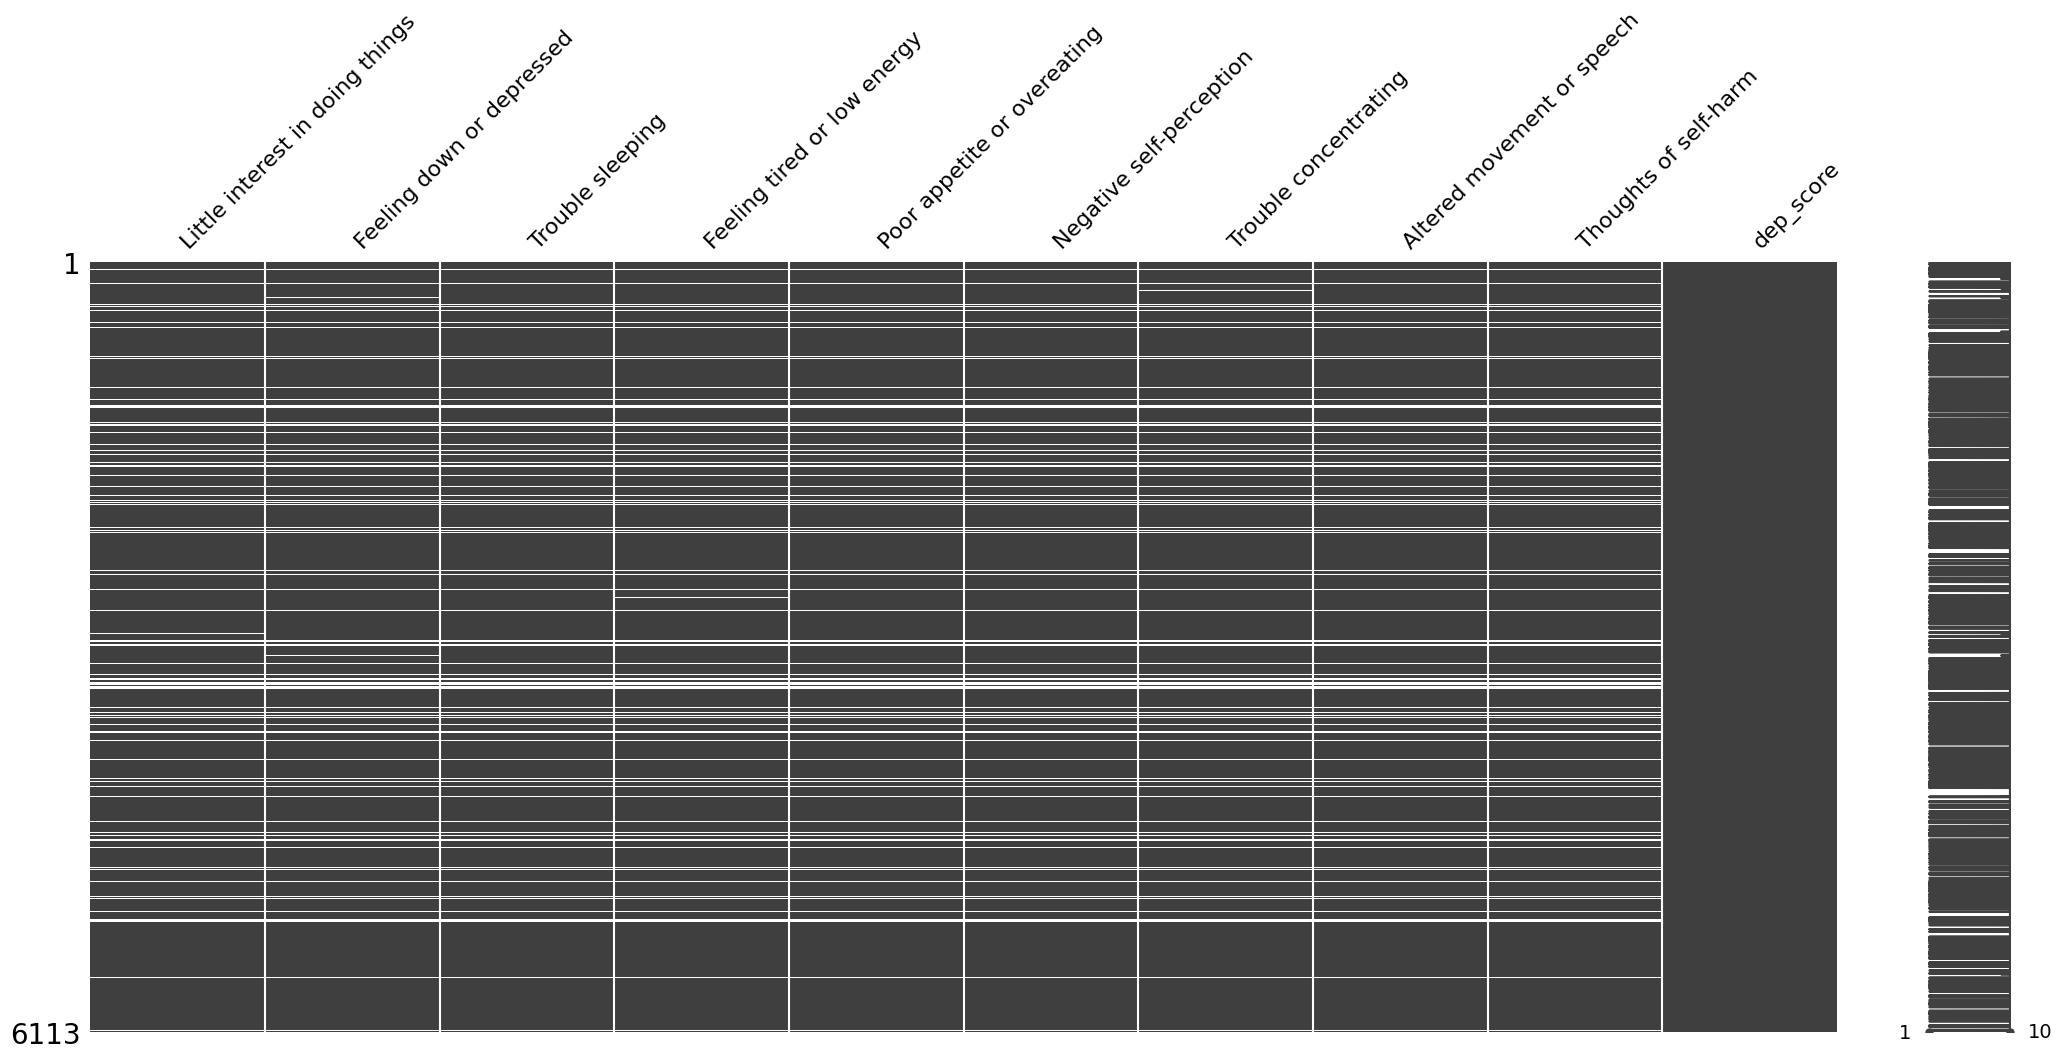

In [ ]:
depression_columns=list(column_mapping_DEPRESSION.values())
all_cols = depression_columns + ['dep_score']
clean_df[all_cols].describe()

# Calculate the number of missing values in each column
num_missing = clean_df[all_cols].isnull().sum()

# Print the number of missing values for each column
print(num_missing)

# Create a missing value matrix plot using missingno
# msno.matrix(clean_df[column_mapping_DEPRESSION.values()].sort_values())
all_cols = depression_columns + ['dep_score']
msno.matrix(clean_df[all_cols])

In [ ]:
clean_df['dep_score'].describe()

count    6113.000000
mean        2.933911
std         4.275855
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        27.000000
Name: dep_score, dtype: float64

# Creating Is_depressed Column

In [ ]:
clean_df['is_depressed']=np.nan
# Mark 1 for values greater than 10 for high risk Depression, 0 as low risk
clean_df.loc[clean_df['dep_score']>=10,'is_depressed']=1
clean_df.loc[clean_df['dep_score']<10,'is_depressed']=0


# Data Visualizations


In [ ]:
#Loading Dataset
clean_df = pd.read_csv('/content/drive/My Drive/master_df_age_cleaned.csv')
clean_df = clean_df.drop(clean_df.columns[0], axis=1)

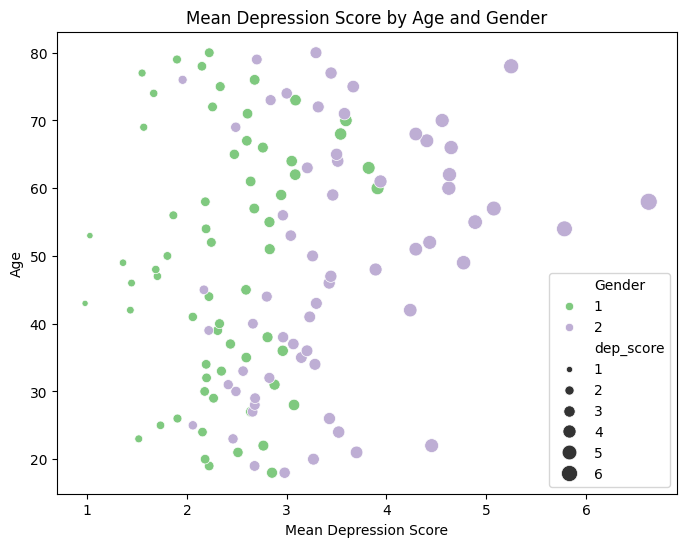

In [ ]:
# Calculate the mean dep_score for each combination of Age and Gender
mean_dep_score = clean_df.groupby(['Age', 'Gender'])['dep_score'].mean().reset_index()

# Create a scatter plot using seaborn to visualize the mean dep_score
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(data=mean_dep_score, x='dep_score', y='Age', hue='Gender',  palette='Accent',size='dep_score', sizes=(20, 150))

# Set the legend labels for color
scatter_plot.set_title('Mean Depression Score by Age and Gender')
# Set the legend for size
scatter_plot._sizes = [100]  # Set the size of the points in the legend
plt.legend( title_fontsize='12', fontsize='10')
plt.xlabel('Mean Depression Score')
plt.grid(False)
plt.show()

<ipython-input-6-87e8691d8843>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['High-Risk','Low-Risk'])


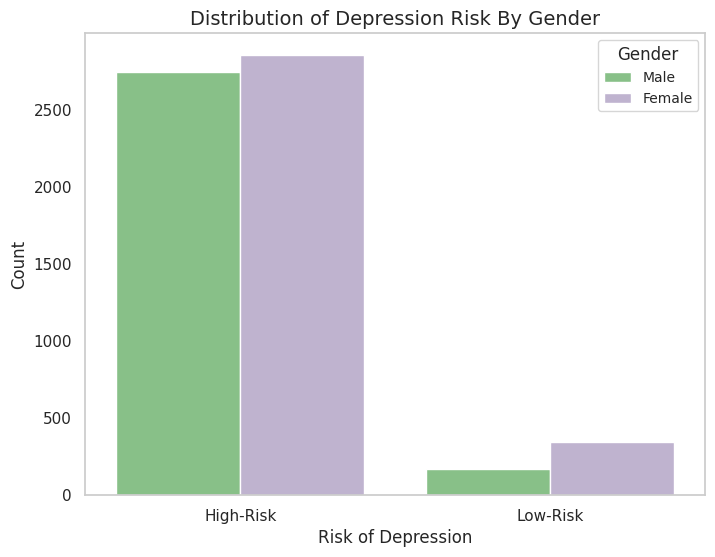

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Create a visually appealing double bar graph using seaborn
ax=sns.countplot(data=clean_df, x='is_depressed', hue='Gender', palette='Accent')
ax.set_xticklabels(['High-Risk','Low-Risk'])
# Set the labels and title
plt.xlabel('Risk of Depression', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Depression Risk By Gender', fontsize=14)
plt.legend(title='Gender', title_fontsize='12', fontsize='10', labels=['Male', 'Female'])
plt.grid(False)
plt.show()


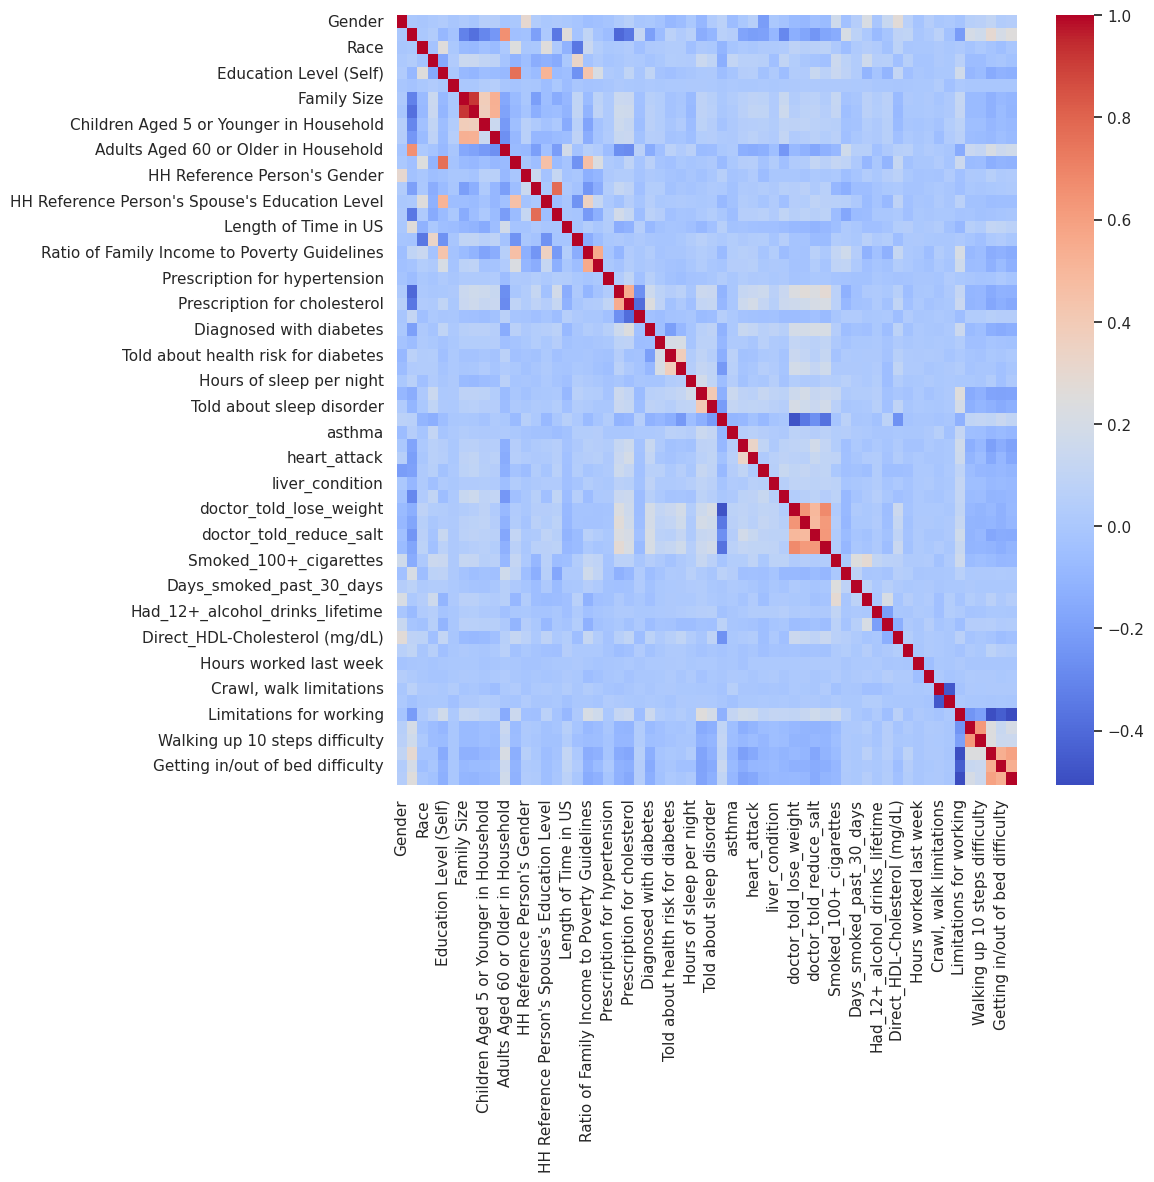

In [ ]:
#Define Data Variables
#removing depression_colums
depression_columns=list(column_mapping_DEPRESSION.values())
all_cols = depression_columns + ['dep_score']
dep_cols=all_cols+['is_depressed','SEQN']
# Calculate the correlation matrix
corr_matrix = clean_df.drop(columns=dep_cols).corr()

fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap of the correlation matrix with only the biggest correlations with absolute value over 0.7 shown
sns.heatmap(corr_matrix, cmap='coolwarm',   linewidths=0)

# Show the plot
plt.show()



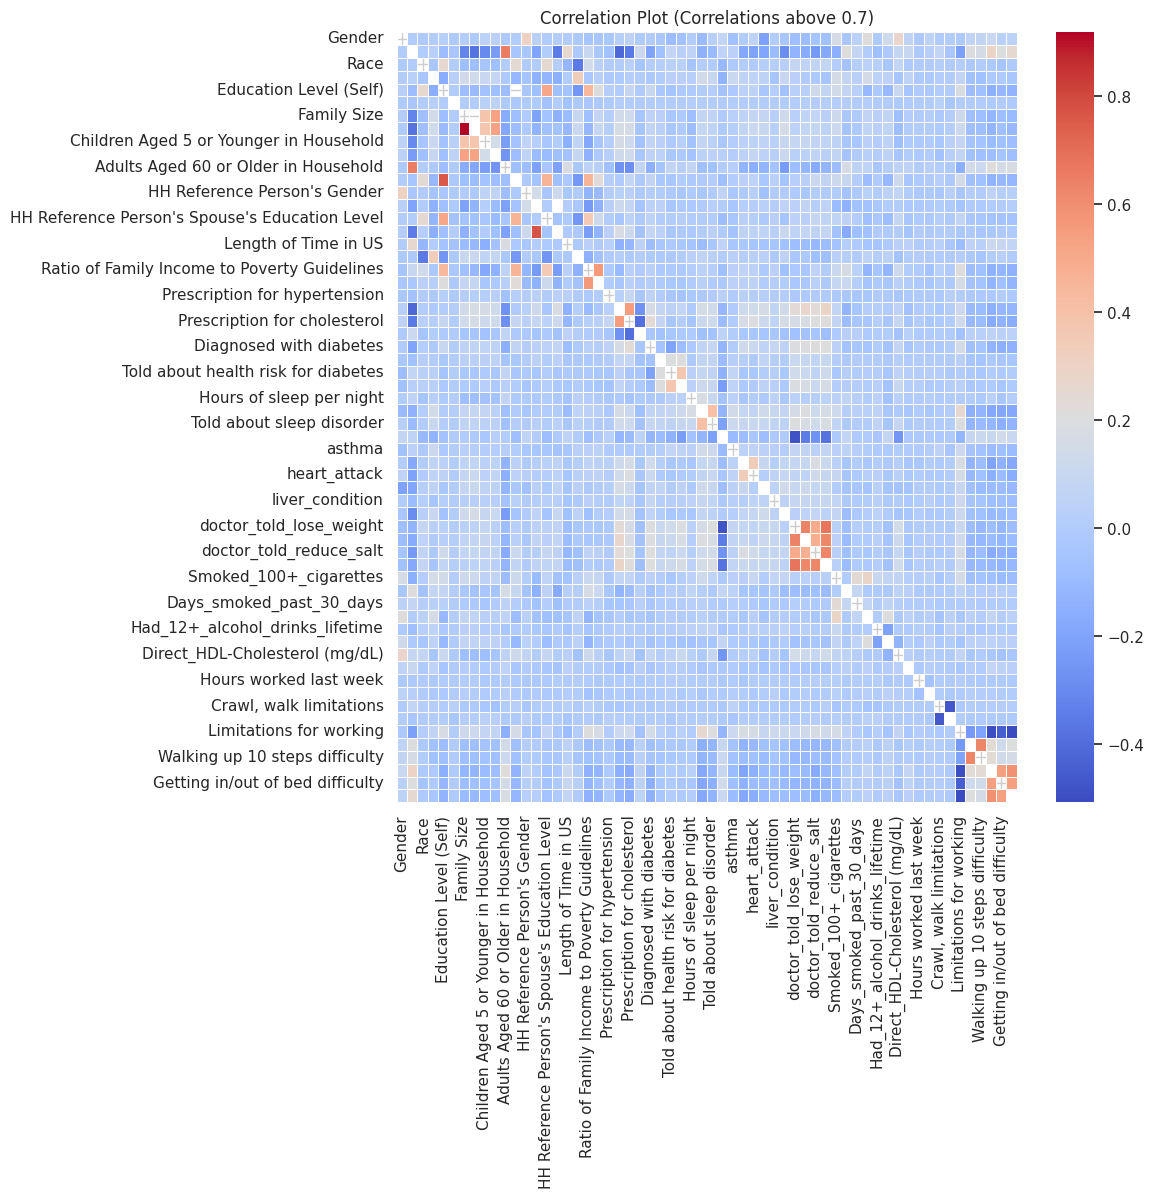

In [ ]:
# Mask the upper triangle
mask = np.triu(corr_matrix > 0.7)

fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap of the correlation matrix with masked values above 0.7
sns.heatmap(corr_matrix, cmap='coolwarm', annot_kws={"fontsize": 7}, linewidths=.5, mask=mask)

# Set the title
ax.set_title('Correlation Plot (Correlations above 0.7)')

# Show the plot
plt.show()


In [ ]:
clean_df[column_mapping_bp.values()].describe()

,Prescription for hypertension,High cholesterol level,Prescription for cholesterol,Taking cholesterol medicine
count,2158.000000,6078.000000,4518.000000,1445.000000
mean,1.161260,1.667654,1.679283,1.213841
std,0.367856,0.471093,0.466804,0.410158
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000,1.000000
75%,1.000000,2.000000,2.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000


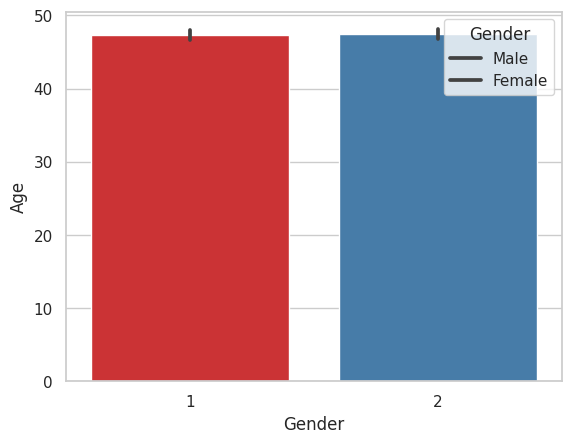

In [ ]:
sns.barplot(data=clean_df, y='Age',x='Gender', palette='Set1')
# Set the legend labels
plt.legend(title='Gender', labels=['Male', 'Female'])

race_dict = {
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    5: 'Other Race - Including Multi-Racial'
}


## For Table Creation

In [ ]:
#Age and Gender
clean_df.groupby('Gender')['Age'].agg(['count', 'mean', 'median']).reset_index()
clean_df.groupby('Gender')['Age'].agg(['count', 'mean', 'median']).reset_index()


,Gender,count,mean,median
0,1,2916,47.294582,47.0
1,2,3197,47.468251,47.0


In [ ]:
#Race
race_dict = {
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    5: 'Other Race - Including Multi-Racial'
}
clean_df['Race'].map(race_dict).value_counts()
# clean_df['Race'].describe()

clean_df.groupby('Race')['Age'].mean()

Race
1    44.112028
2    46.000000
3    50.049008
4    46.986443
5    44.247778
Name: Age, dtype: float64

In [ ]:
clean_df['Education Level (Self)'].value_counts()

4.000000    1770
5.000000    1443
3.000000    1303
2.000000     791
1.000000     455
3.512843     351
Name: Education Level (Self), dtype: int64

In [ ]:
clean_df['Ratio of Family Income to Poverty Guidelines'].describe()

count    6113.000000
mean        2.452008
std         1.584141
min         0.000000
25%         1.060000
50%         2.260000
75%         3.810000
max         5.000000
Name: Ratio of Family Income to Poverty Guidelines, dtype: float64

In [ ]:
clean_df['Age'].describe()

count    6113.000000
mean       47.385408
std        18.468072
min        18.000000
25%        32.000000
50%        47.000000
75%        62.000000
max        80.000000
Name: Age, dtype: float64

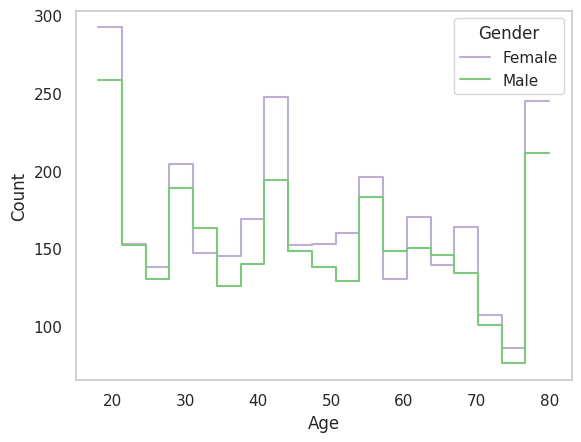

In [ ]:
# Create the histograms
sns.histplot(clean_df, x='Age', hue='Gender', element="step", fill=False,  palette='Accent')
# Add legend
plt.legend(title='Gender', labels=['Female', 'Male'])
# Show the plot
plt.grid(False)
plt.show()


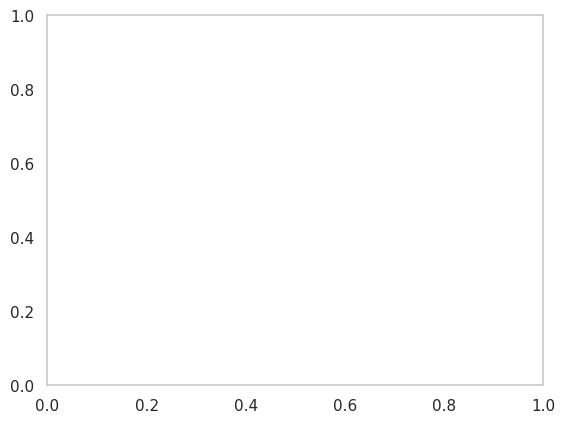

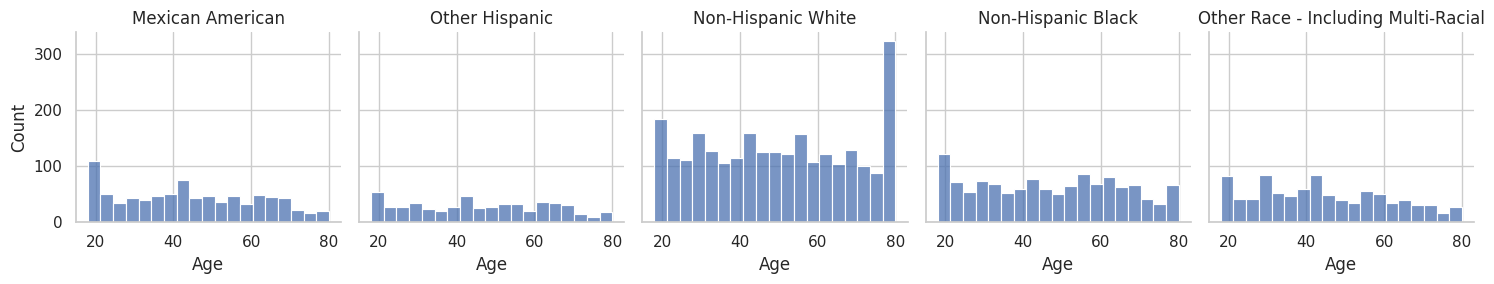

In [ ]:
#Plotting Distributions from Different Races
plt.grid(False)
g = sns.displot(clean_df, x="Age", col="Race", height=3)

for (col_key, ax) in zip(race_dict.values(), g.axes.flat):
    ax.set_title(col_key)
plt.show()


In [ ]:
clean_df.groupby(['Race','Age']).count()

Little interest in doing things  Feeling down or depressed  \
Race Age                                                               
1    18                                43                         43   
     19                                38                         38   
     20                                15                         15   
     21                                13                         13   
     22                                14                         14   
...                                   ...                        ...   
5    76                                 3                          3   
     77                                 2                          2   
     78                                 4                          4   
     79                                 1                          1   
     80                                21                         21   

          Trouble sleeping  Feeling tired or low energy  \
Race Age                                                  
1    18                 43                           43   
     19                 38                           38   
     20                 15                           15   
     21                 13                           13   
     22                 14                           14   
...                    ...                          ...   
5    76                  3                            3   
     77                  2                            2   
     78                  4                            4   
     79                  1                            1   
     80                 21                           21   

          Poor appetite or overeating  Negative self-perception  \
Race Age                                                          
1    18                            43                        43   
     19                            38                        38   
     20                            15                        15   
     21                            13                        13   
     22                            14                        14   
...                               ...                       ...   
5    76                             3                         3   
     77                             2                         2   
     78                             4                         4   
     79                             1                         1   
     80                            21                        21   

          Trouble concentrating  Altered movement or speech  \
Race Age                                                      
1    18                      43                          43   
     19                      38                          38   
     20                      15                          15   
     21                      13                          13   
     22                      14                          14   
...                         ...                         ...   
5    76                       3                           3   
     77                       2                           2   
     78                       4                           4   
     79                       1                           1   
     80                      21                          21   

          Thoughts of self-harm  SEQN  ...  Crawl, walk limitations  \
Race Age                               ...                            
1    18                      43    43  ...                       43   
     19                      38    38  ...                       38   
     20                      15    15  ...                       15   
     21                      13    13  ...                       13   
     22                      14    14  ...                       14   
...                         ...   ...  ...                      ...   
5    76                       3     3  ...   

In [ ]:
clean_df.groupby('Race')['Annual  Household Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Race,,,,,,,,
1,1487.0,1.589106,0.730946,1.0,1.0,1.0,2.0,3.0
2,775.0,1.605161,0.732398,1.0,1.0,1.0,2.0,3.0
3,2709.0,1.659653,0.756117,1.0,1.0,1.0,2.0,3.0
4,1990.0,1.547739,0.697970,1.0,1.0,1.0,2.0,3.0
5,973.0,1.796506,0.754757,1.0,1.0,2.0,2.0,3.0


<Axes: >

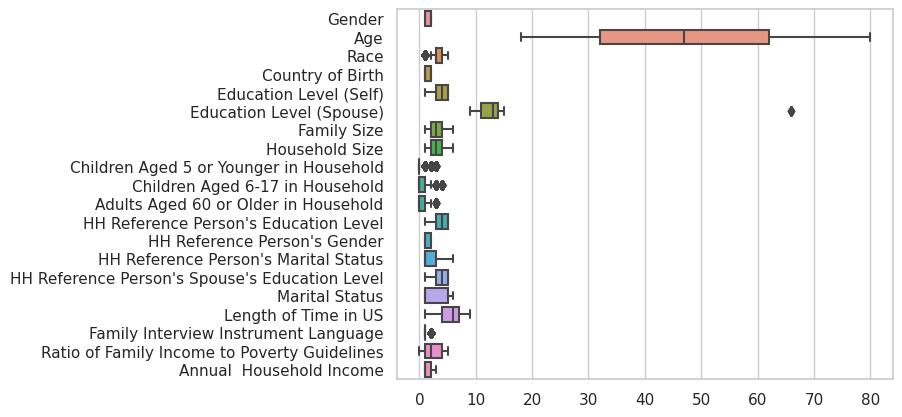

In [ ]:
sns.boxplot(data=clean_df[dem_columns.values()].drop(columns='SEQN'), orient="h")


In [ ]:
dictionary_names = [column_mapping_DEPRESSION, dem_columns, column_mapping_bp, column_mapping_health_symtpmoms, chronic_disease, smoking, labs, work_behavior, physical_activity]


## Clean Outliers

In [ ]:
#Clean Outliers based on IQR upper and lower bounds, if theres a lot of outliers use
# median instead of mean to extrapolate missing values
for column in clean_df.columns:
    if clean_df[column].dtype != 'object':  # Check if the column is numeric
        q1 = clean_df[column].quantile(0.25)
        q3 = clean_df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        if (clean_df[column] < lower_bound).any() or (clean_df[column] > upper_bound).any():
            clean_df[column].fillna(clean_df[column].median(), inplace=True)
        else:
            clean_df[column].fillna(clean_df[column].mean(), inplace=True)

In [ ]:
clean_df.isnull().sum()

Little interest in doing things     0
Feeling down or depressed           0
Trouble sleeping                    0
Feeling tired or low energy         0
Poor appetite or overeating         0
                                   ..
Lifting or carrying difficulty      0
Getting in/out of bed difficulty    0
Going out to events difficulty      0
dep_score                           0
is_depressed                        0
Length: 72, dtype: int64

In [ ]:
clean_df.columns

Index(['Little interest in doing things', 'Feeling down or depressed',
       'Trouble sleeping', 'Feeling tired or low energy',
       'Poor appetite or overeating', 'Negative self-perception',
       'Trouble concentrating', 'Altered movement or speech',
       'Thoughts of self-harm', 'SEQN', 'Gender', 'Age', 'Race',
       'Country of Birth', 'Education Level (Self)',
       'Education Level (Spouse)', 'Family Size', 'Household Size',
       'Children Aged 5 or Younger in Household',
       'Children Aged 6-17 in Household',
       'Adults Aged 60 or Older in Household',
       'HH Reference Person's Education Level', 'HH Reference Person's Gender',
       'HH Reference Person's Marital Status',
       'HH Reference Person's Spouse's Education Level', 'Marital Status',
       'Length of Time in US', 'Family Interview Instrument Language',
       'Ratio of Family Income to Poverty Guidelines',
       'Annual  Household Income', 'Prescription for hypertension',
       'High cholester

In [ ]:
clean_df.isnull().sum().sort_values()

Little interest in doing things          0
doctor_told_reduce_fat_calories          0
doctor_told_reduce_salt                  0
doctor_told_exercise                     0
doctor_told_lose_weight                  0
                                        ..
HH Reference Person's Education Level    0
Adults Aged 60 or Older in Household     0
Children Aged 6-17 in Household          0
dep_score                                0
is_depressed                             0
Length: 72, dtype: int64

In [ ]:
clean_df.groupby('Annual  Household Income')['Household Size'].count()

Annual  Household Income
1.000000    2367
1.656277    1397
2.000000    1603
3.000000     746
Name: Household Size, dtype: int64

# Load DataSet from Drive

In [ ]:
# master_df=clean_df.drop(clean_df.columns[:1], axis=1)
master_df=clean_df
# master_df.to_csv('/content/drive/My Drive/master_df_age_cleaned.csv')

In [ ]:
# #Clean DF Saving

# master_df.to_csv('/content/drive/My Drive/master_df.csv')
# # Load from Google Drive
master_df = pd.read_csv('/content/drive/My Drive/master_df_age_cleaned.csv')

In [ ]:
clean_df.columns
# master_df.columns

Index(['Little interest in doing things', 'Feeling down or depressed',
       'Trouble sleeping', 'Feeling tired or low energy',
       'Poor appetite or overeating', 'Negative self-perception',
       'Trouble concentrating', 'Altered movement or speech',
       'Thoughts of self-harm', 'SEQN', 'Gender', 'Age', 'Race',
       'Country of Birth', 'Education Level (Self)',
       'Education Level (Spouse)', 'Family Size', 'Household Size',
       'Children Aged 5 or Younger in Household',
       'Children Aged 6-17 in Household',
       'Adults Aged 60 or Older in Household',
       'HH Reference Person's Education Level', 'HH Reference Person's Gender',
       'HH Reference Person's Marital Status',
       'HH Reference Person's Spouse's Education Level', 'Marital Status',
       'Length of Time in US', 'Family Interview Instrument Language',
       'Ratio of Family Income to Poverty Guidelines',
       'Annual  Household Income', 'Prescription for hypertension',
       'High cholester

# Model Development


In [ ]:
#Importing Model Metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold



In [ ]:
#Load saved dataset
master_df = pd.read_csv('/content/drive/My Drive/master_df_age_cleaned.csv')

#Define Data Variables
#removing depression_colums and SEGN column with ID number
depression_columns=list(column_mapping_DEPRESSION.values())
all_cols = depression_columns + ['dep_score']
dep_cols=all_cols+['is_depressed','SEQN']
X=master_df.drop(columns=dep_cols)

y=master_df['is_depressed']

In [ ]:
# Shuffle your data
X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('size of training',X_train.shape)
print('size of test', X_test.shape)



size of training (4890, 60)
size of test (1223, 60)


In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_train, X_test):
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test


X_train, X_test=preprocess_data(X_train, X_test)

In [ ]:
# Resample the training set using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.shape

(8922,)

In [ ]:
y_train.value_counts()
y_train_resampled.value_counts()

0.0    4461
1.0    4461
Name: is_depressed, dtype: int64

In [ ]:
# # Select the most important features using SelectFromModel
# selector = SelectFromModel(estimator=RandomForestClassifier(random_state=42))
# X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
# X_test_selected = selector.transform(X_test)

In [ ]:
X_train_resampled.shape

(8922, 60)

In [ ]:
X_train.shape

(4890, 60)

In [ ]:
# Fit XGBoost classifier on the resampled and selected features data
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)
y_pred = xgb.predict(X_test)

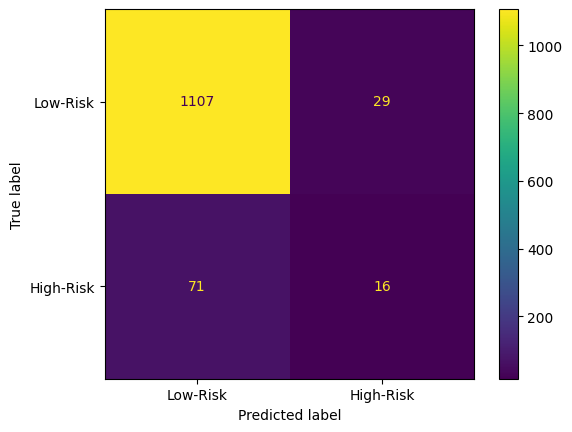

Accuracy: 0.9182338511856092


In [ ]:
from sklearn import metrics

# Assuming y_test contains the actual values
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Low-Risk','High-Risk'])

# Label the confusion matrix

cm_display.plot()
plt.grid(False)
plt.show()

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


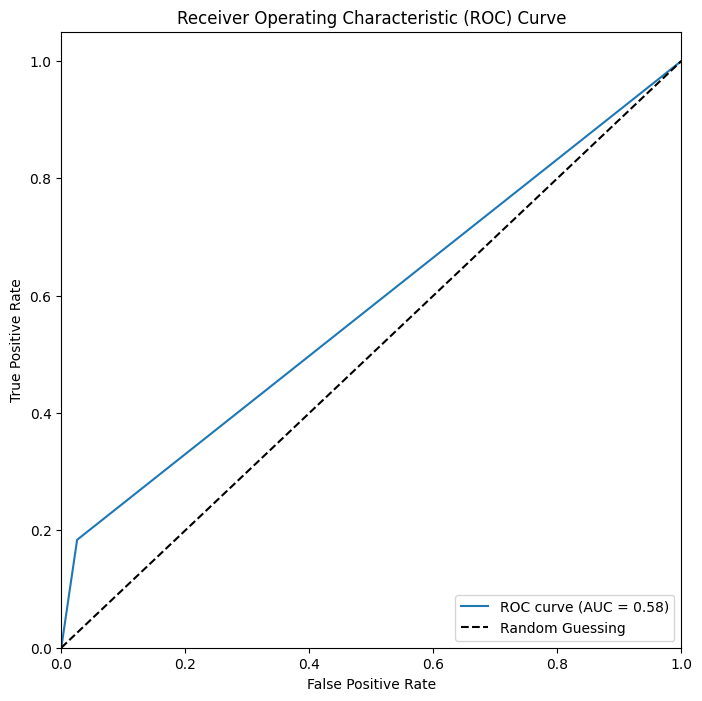

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

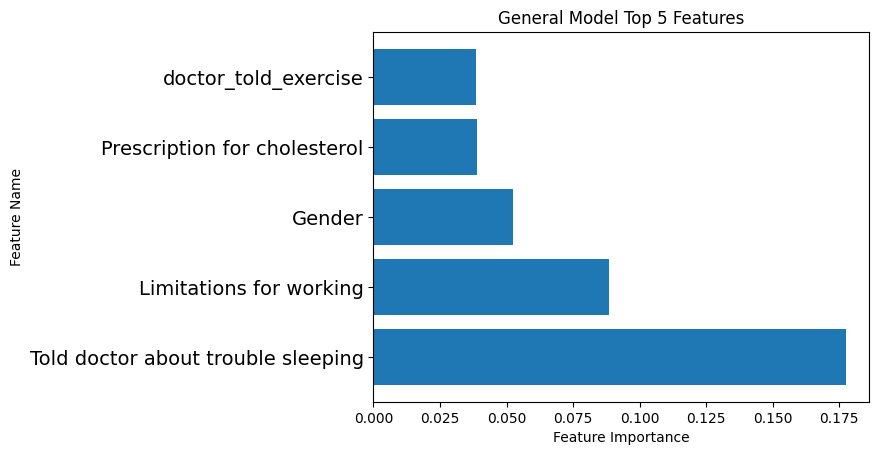

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Calculate feature importance
feature_importance = xgb.feature_importances_
feature_names = X.columns

# Plot feature importance for the top 5 features
top_features = feature_importance.argsort()[-5:][::-1]
plt.barh(feature_names[top_features], feature_importance[top_features])

plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('General Model Top 5 Features')
plt.yticks(fontsize=14)

# Turn off the grid lines
plt.grid(False)
plt.show()


In [ ]:
#Extract names of top featues and save for future venn diagram
general_m=feature_names[top_features]
print(general_m)

Index(['Told doctor about trouble sleeping', 'Limitations for working',
       'Gender', 'Prescription for cholesterol', 'doctor_told_exercise'],
      dtype='object')


In [ ]:
from sklearn.model_selection import cross_val_score
# Evaluate the model performance using 5-fold cross-validation
cv_scores = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
acc_scores = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print the cross-validation scores and their mean
print('Cross-Validation ROC-AUC Scores: ', cv_scores)
print('Mean Cross-Validation ROC-AUC Score: ', cv_scores.mean())

Cross-Validation ROC-AUC Scores:  [0.93166206 0.99998117 0.99997235 0.99980519 0.99993967]
Mean Cross-Validation ROC-AUC Score:  0.9862720882795053


In [ ]:
!pip install shap
import shap

[16:05:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


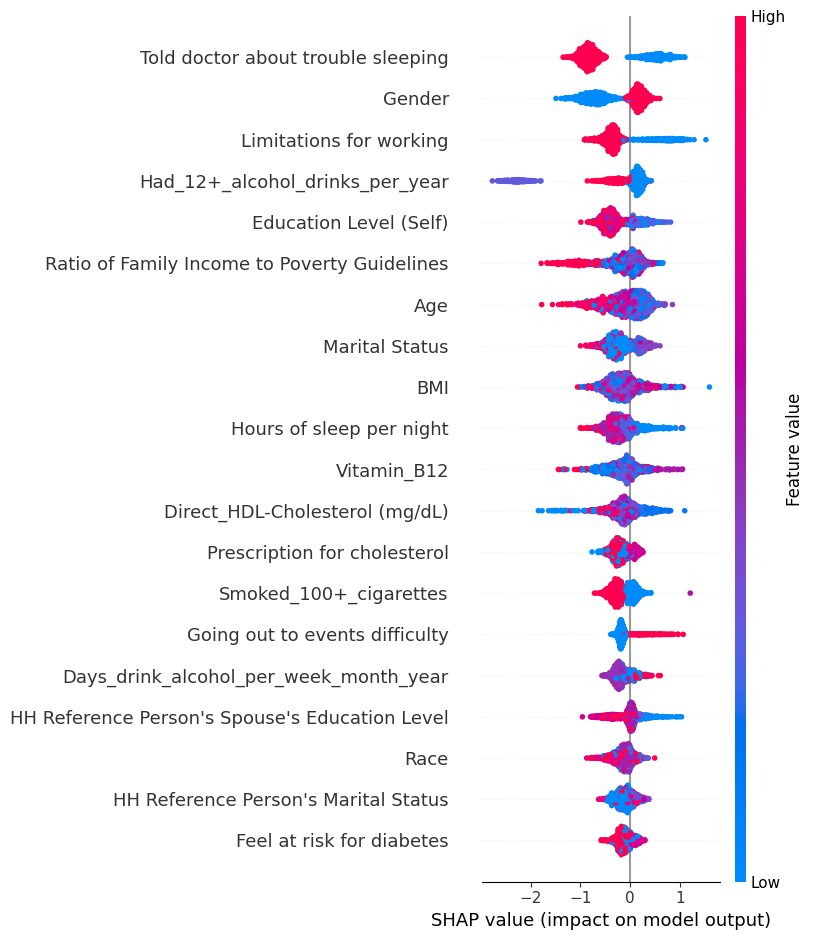

In [ ]:
#General Model
#yes 1 no 2
# Create the explainer
explainer = shap.TreeExplainer(xgb)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot with feature names
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
